(bart_heteroscedasticity)=
# Modeling Heteroscedasticity with BART

:::{post} January, 2023
:tags: bart regression 
:category: beginner, reference
:author: [Juan Orduz](https://juanitorduz.github.io/)
:::

In this notebook we show how to use BART to model heteroscedasticity as described in Section 4.1 of [`pymc-bart`](https://github.com/pymc-devs/pymc-bart)'s paper [Bayesian additive regression trees for probabilistic programming](https://arxiv.org/abs/2206.03619).

In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
%config InlineBackend.figure_format = "retina"
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
rng = np.random.default_rng(42)

In [3]:
try:
    df = pd.read_csv(os.path.join("..", "data", "marketing.csv"), sep=";", decimal=",")
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("marketing.csv"), sep=";", decimal=",")

n_obs = df.shape[0]

df.head()

,youtube,facebook,newspaper,sales
0,276.12,45.36,83.04,26.52
1,53.40,47.16,54.12,12.48
2,20.64,55.08,83.16,11.16
3,181.80,49.56,70.20,22.20
4,216.96,12.96,70.08,15.48


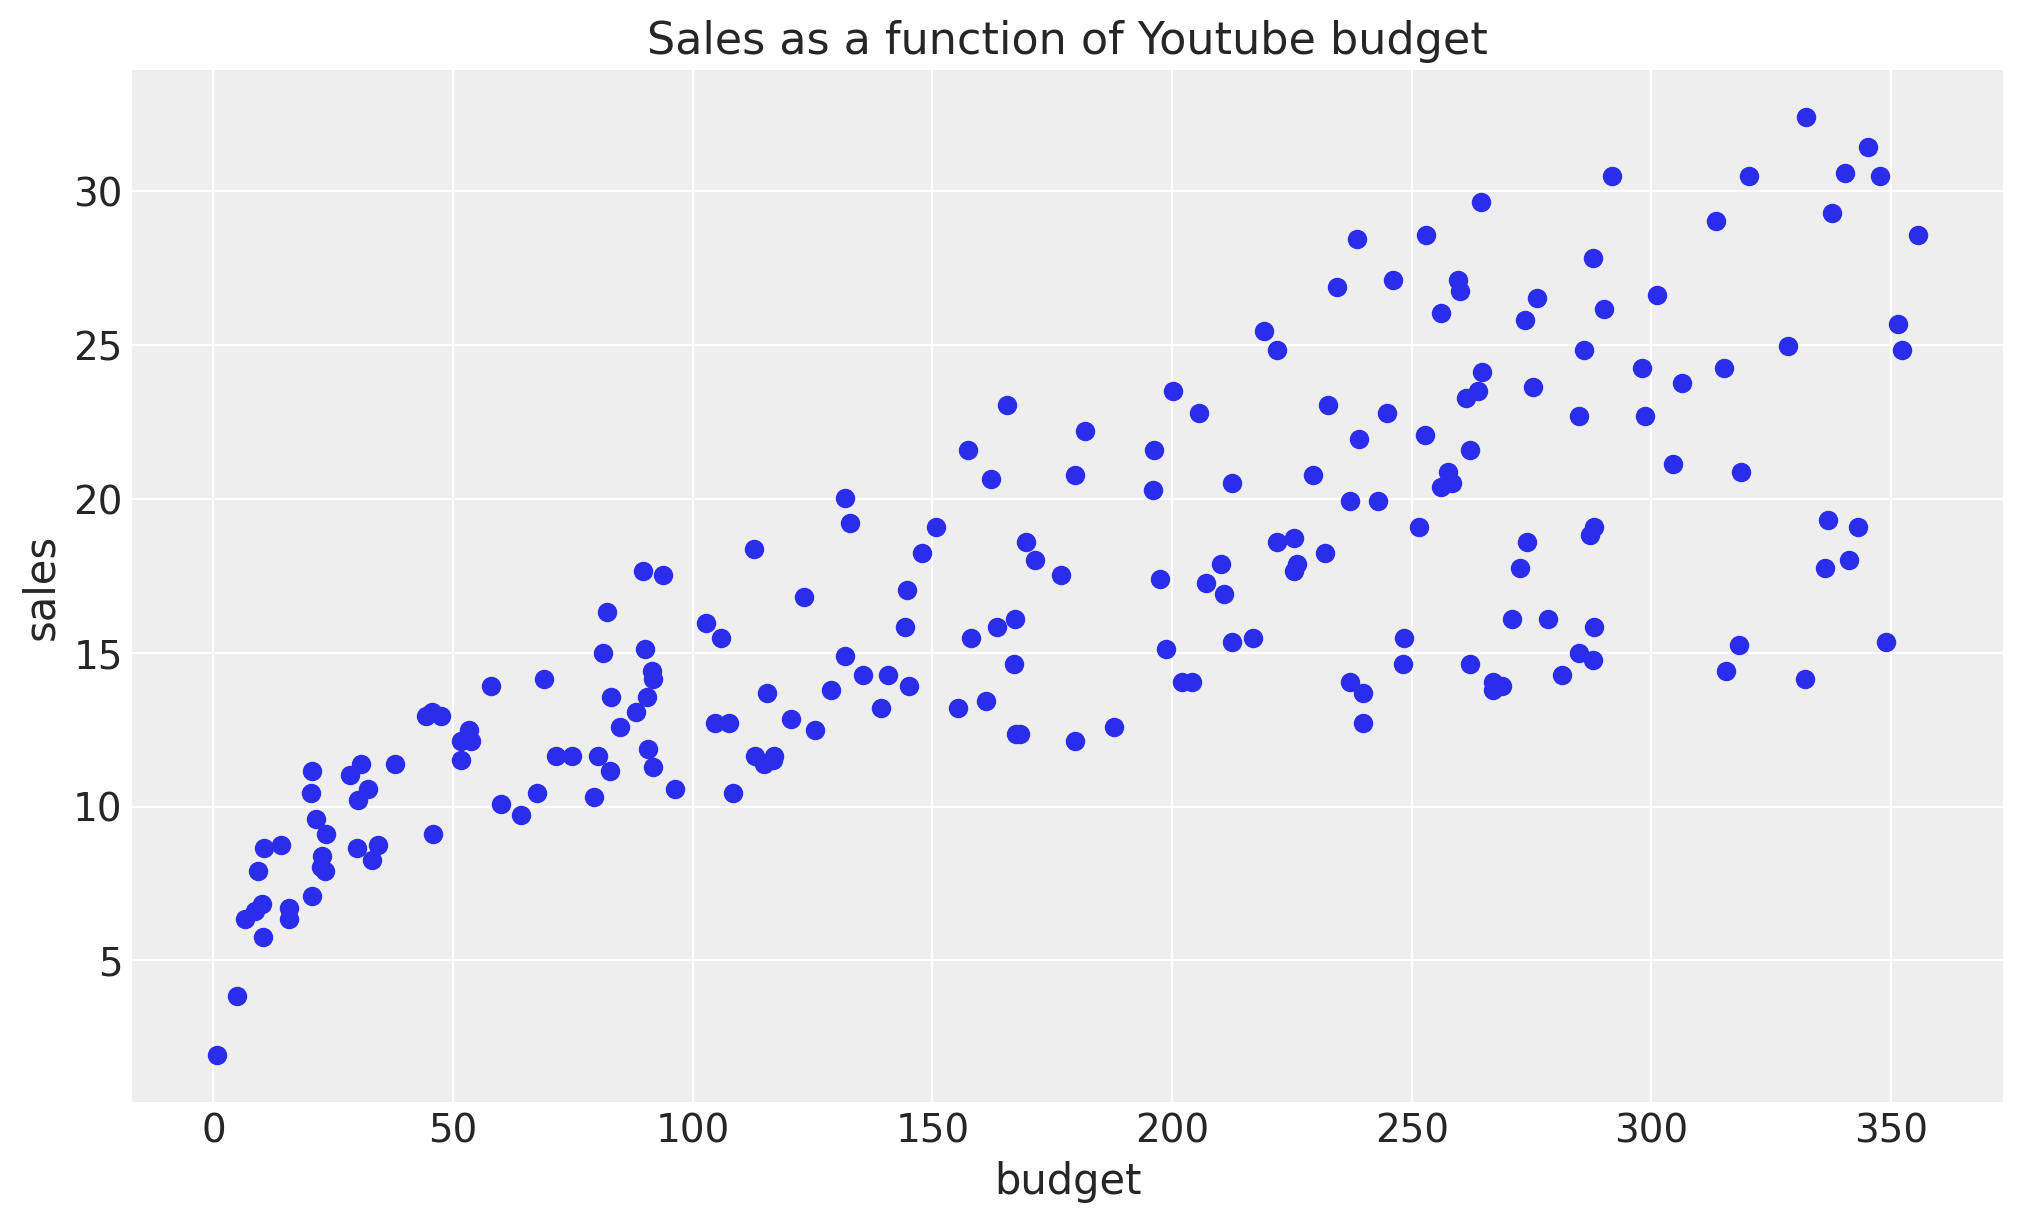

In [4]:
fig, ax = plt.subplots()
ax.plot(df["youtube"], df["sales"], "o", c="C0")
ax.set(title="Sales as a function of Youtube budget", xlabel="budget", ylabel="sales");

In [6]:
X = df["youtube"].to_numpy().reshape(-1, 1)
Y = df["sales"].to_numpy()#.reshape(-1, 1)

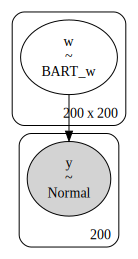

In [7]:
with pm.Model() as model_marketing_full:
    w = pmb.BART(name="w", X=X, Y=Y, m=50, shape=(n_obs, 2))
    y = pm.Normal(name="y", mu=w[:, 0], sigma=pm.math.abs(w[:, 1]), observed=Y)

pm.model_to_graphviz(model=model_marketing_full)

In [8]:
with model_marketing_full:
    idata_marketing_full = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 376 seconds.


In [40]:
hdi = az.hdi(idata_marketing_full)

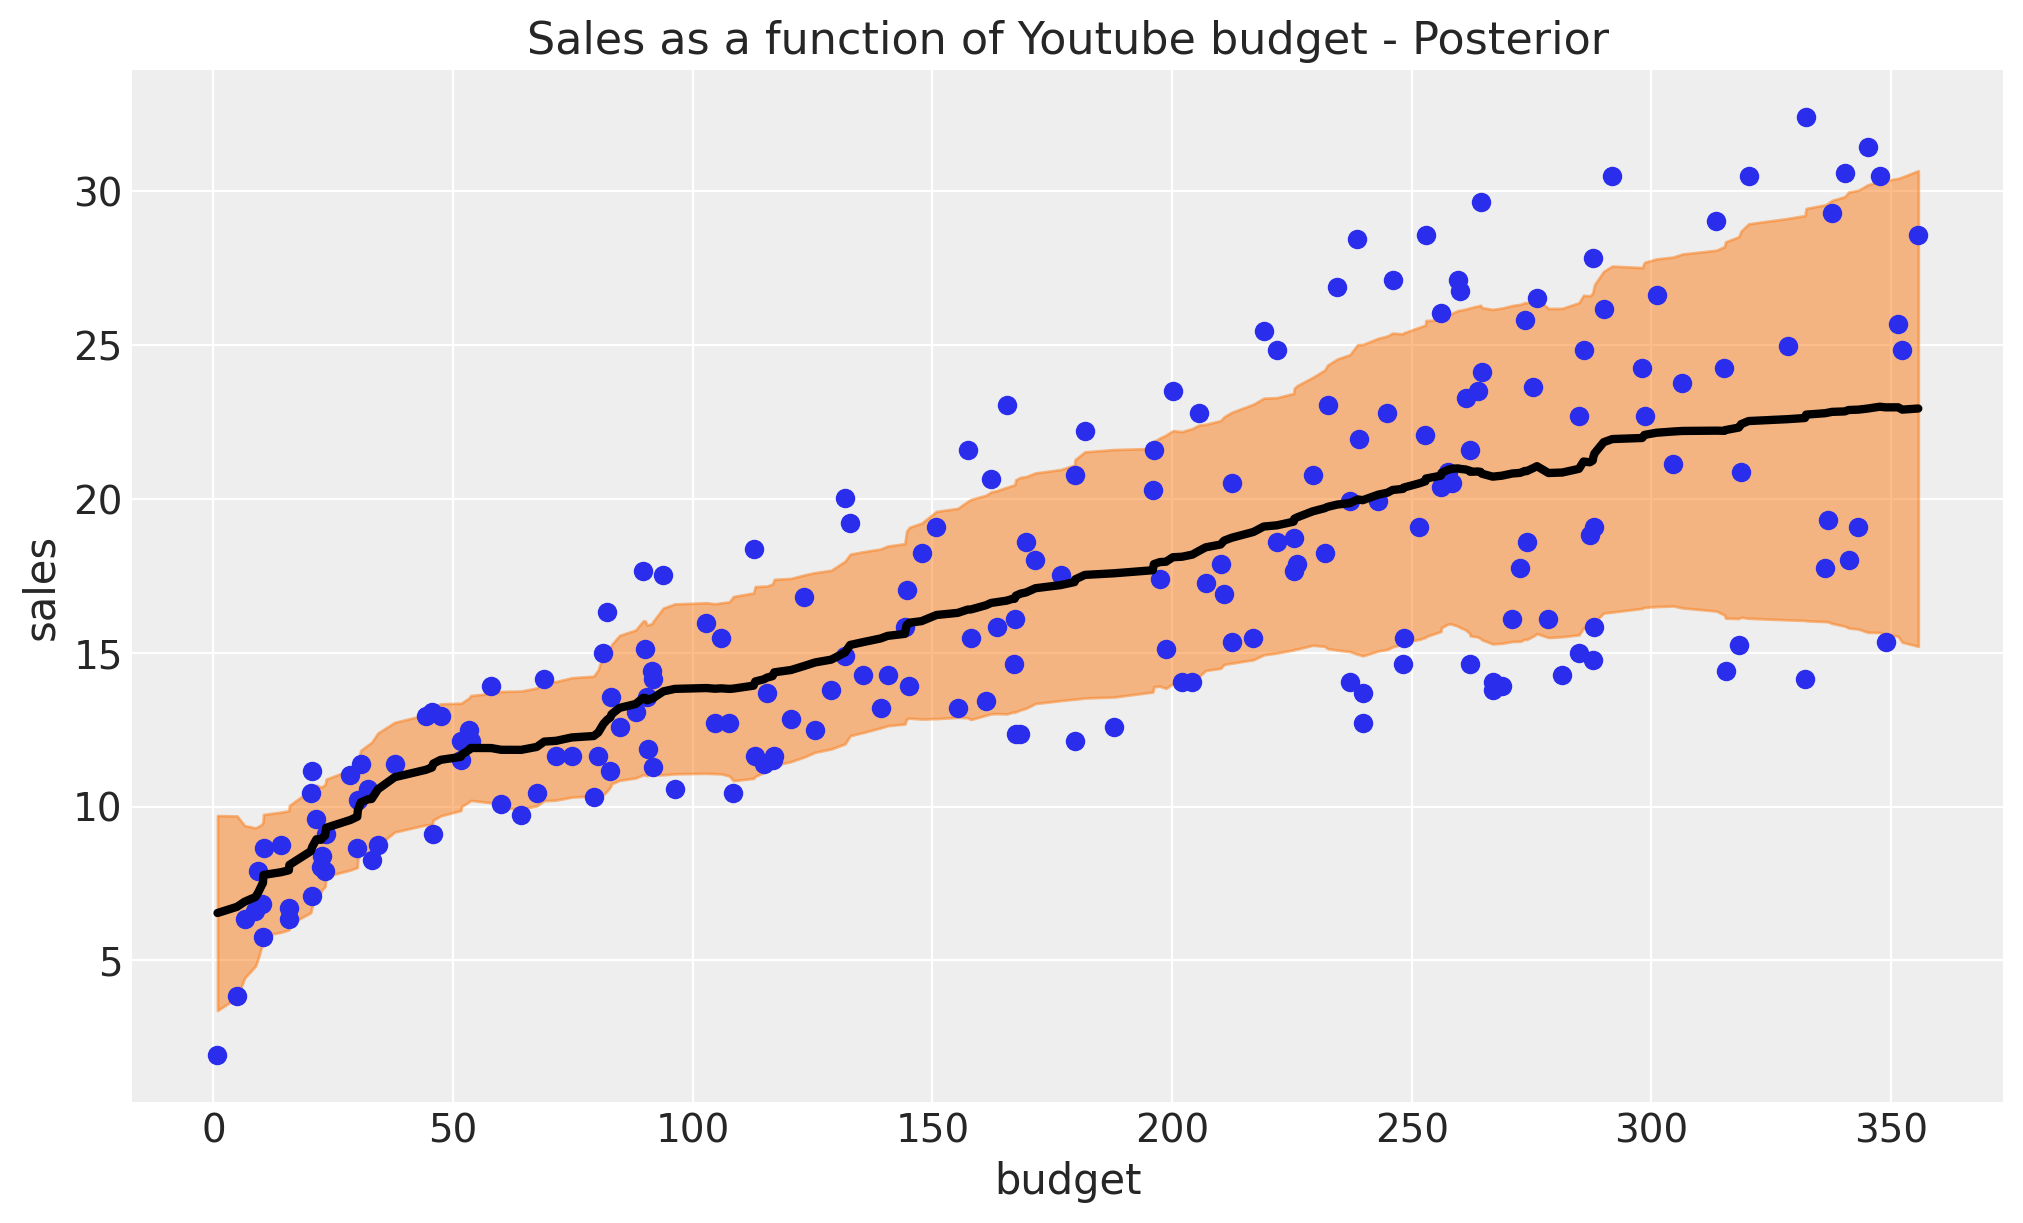

In [30]:
posterior = az.extract(data=idata_marketing_full, var_names="w")

idx = np.argsort(X[:, 0])

mean = posterior.mean("sample")[:, 0][idx]

sigma  = np.abs(posterior.mean("sample")[:, 1])[idx]

fig, ax = plt.subplots()
ax.plot(df["youtube"], df["sales"], "o", c="C0")
ax.fill_between(X[:, 0][idx], mean - sigma, mean + sigma, color="C1", alpha=0.5)
ax.plot(X[:, 0][idx], mean, c="black", lw=3)
ax.set(title="Sales as a function of Youtube budget - Posterior", xlabel="budget", ylabel="sales");


## Authors
- Authored by [Juan Orduz](https://juanitorduz.github.io/) in February 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

:::{include} ../page_footer.md
:::